# Part 0: Hello Qiskit Pulse (Qiskit pulse 소개)

Qiskit-Pulse is a open-source pulse-level quantum programming kit. This lower level of programming offers the user more control than programming with the QuantumCircuit.

Qiskit pulse는 오픈소스, 펄스 신호 수준의 양자 프로그래밍 키트입니다. 사용자는 이 하드웨어에 더 가까이 작용하는 프로그래밍 언어를 사용해 양자 게이트보다 큐빗에 더 많은 작업을 할 수 있게 됩니다.

Qiskit Pulse was release public by this paper, 14 Apr 2020: https://arxiv.org/abs/2004.06755 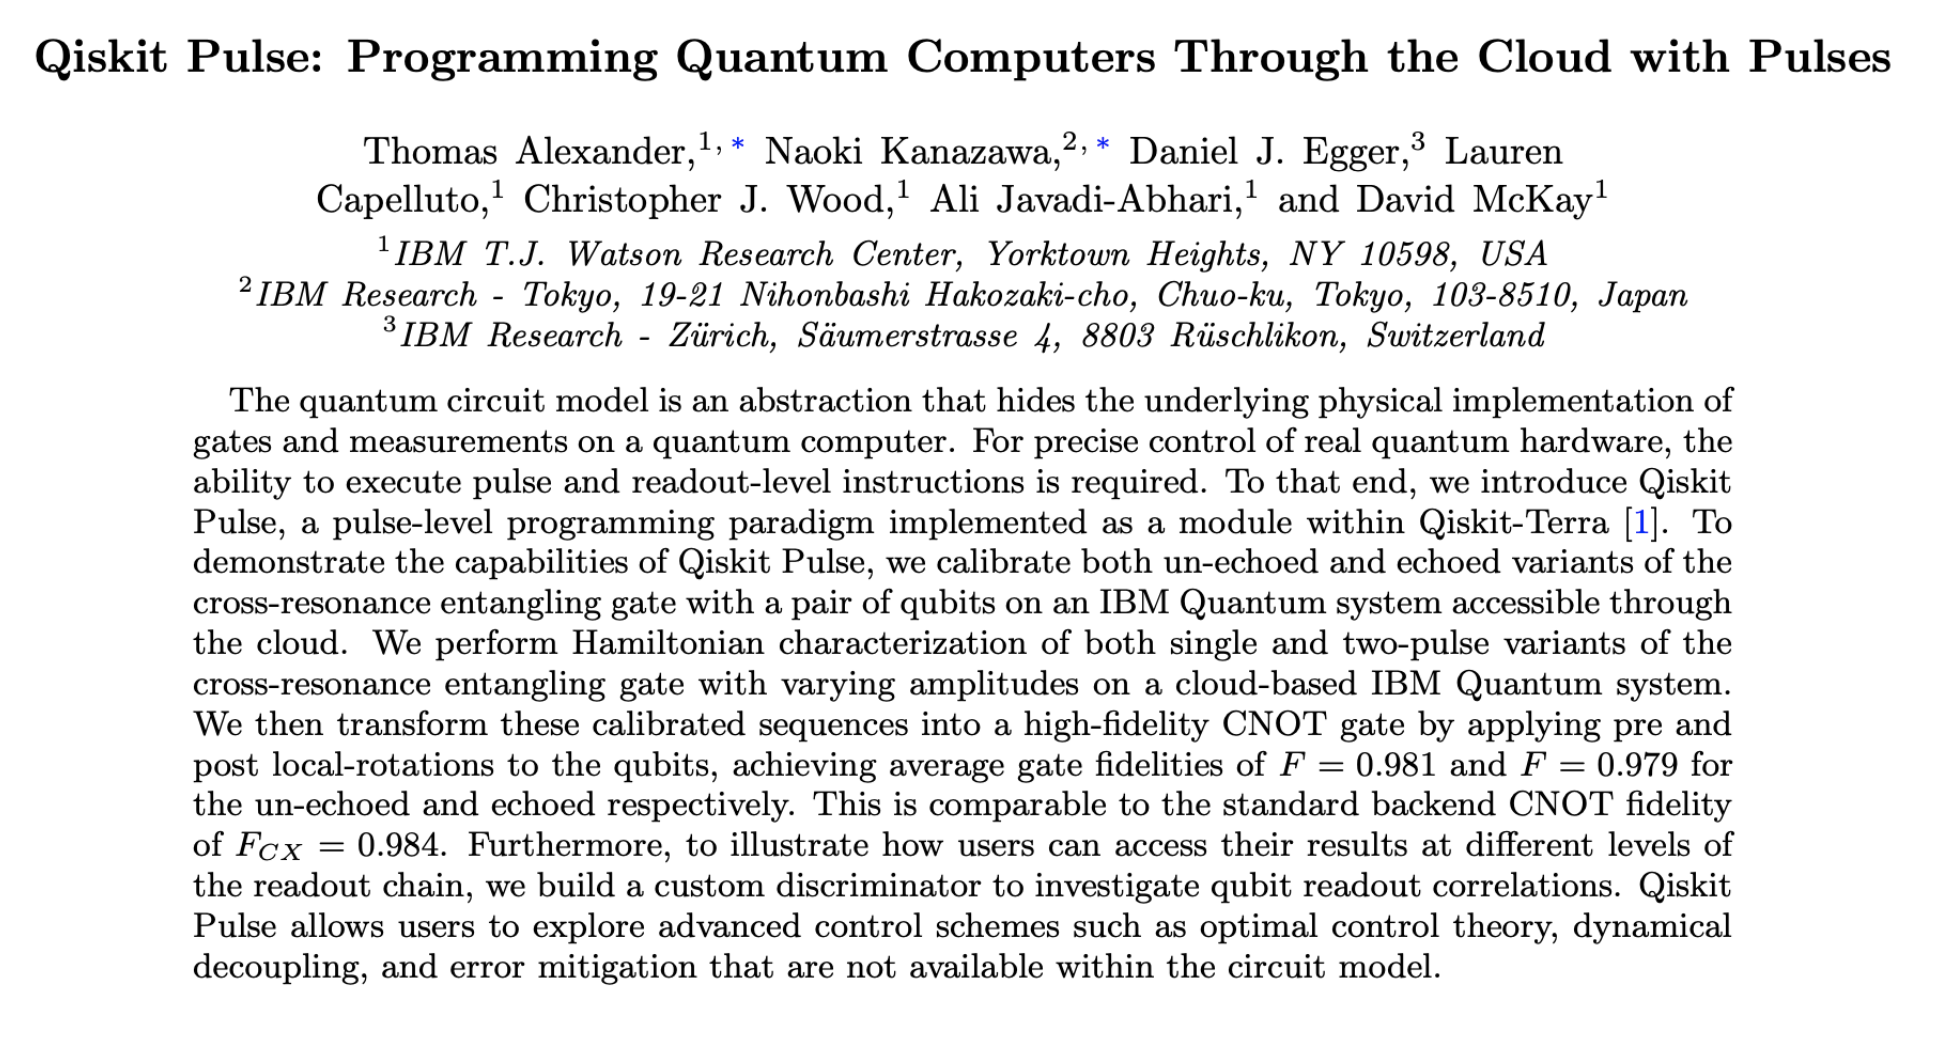

Qiskit pulse는 다음의 2020년 4월 14일에 발표된 논문으로 최초로 공개되었습니다: https://arxiv.org/abs/2004.06755


The main motivation of the Qiskit pulse is provide hardware level access to the users mainly for:
- Optimal control upon the quantum hardware https://www.nature.com/articles/s41534-020-00346-2
- Error mitigation https://www.nature.com/articles/s41586-019-1040-7 
- Dynamical decoupling https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.1.020318 

Qiskit Pulse의 주요 목적은 사용자에게 다음의 기능을 제공하는 것입니다
- 양자 하드웨어에 대한 최적의 제어: https://www.nature.com/articles/s41534-020-00346-2
- 에러 완화: https://www.nature.com/articles/s41586-019-1040-7 
- Dynamical decoupling: https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.1.020318 


# Part1: Qiskit Pulse Basic (Qiskit Pulse 기본 연습)

At here I wanto to give you some brief explanation about how the pulse control works with the superconducting qubit. 

초전도 큐비트에 펄스 제어가 어떻게 작동하는지 간단하게 알아보겠습니다. 
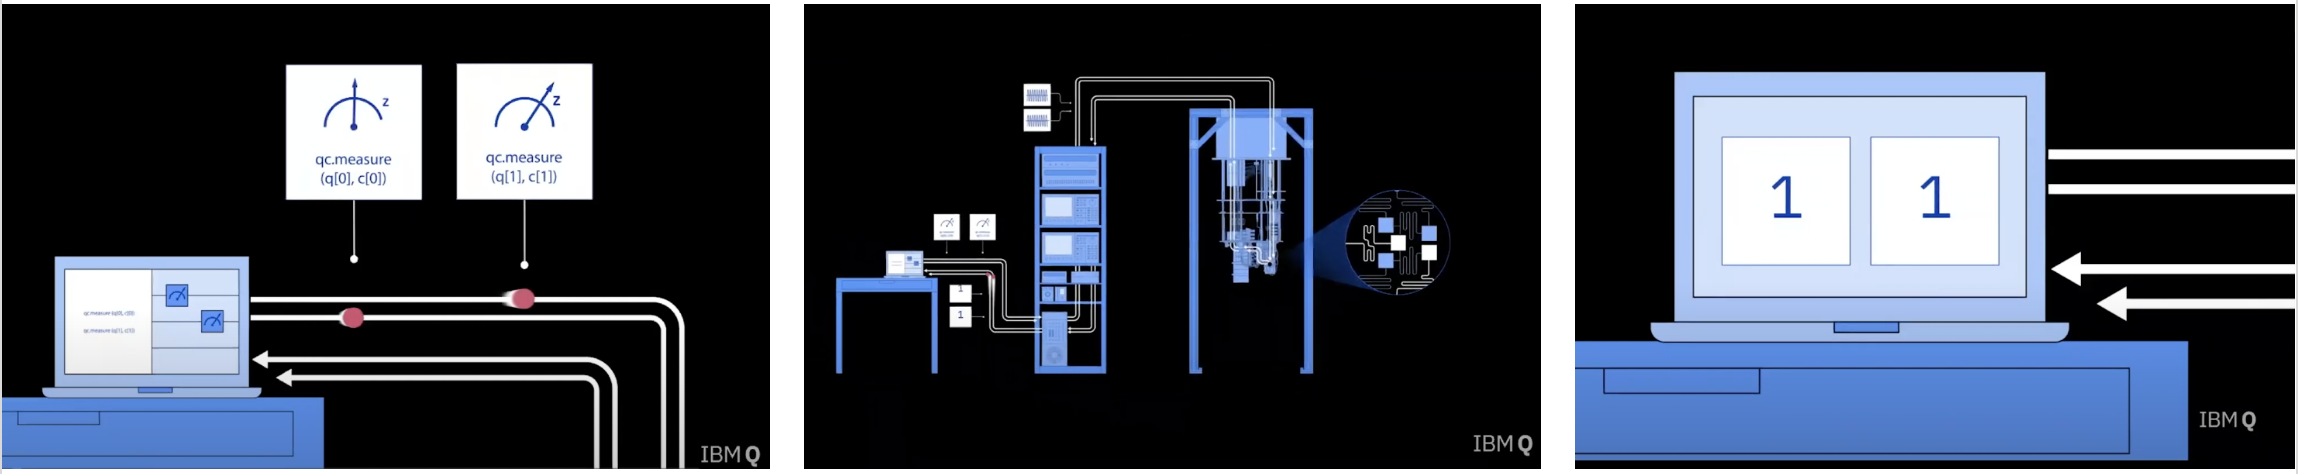

When we compose a quantum circuit by using QuantumCircuit, it is transpiled into basis gates according to each backend and defines the register to perform the "measurement". The Qiskit sends this information - The circuit information and the register information - to the quantum backend through its cloud API, then it composes the actual pulse signal series to work with the superconducting qubit and do actual experiments upon the quantum hardware. After getting the measurement result by reading the classical register, the Qiskit API delivers this result to us.

여러분이 QuantumCircuit을 사용해 양자 회로를 작성하고나면, 이 회로는 양자백엔드에서 실행 가능한 기본 게이트들로 transpile된 후 측정 값을 저장하기 위한 몇가지 레지스터의 값들이 할당되게 됩니다. Qiskit은 이 정보 - 회로와 레지스터의 정보들 - 를 Cloud API를 사용해 양자백엔드로 전송하고 이 정보들은 초전도 큐비트에 작용하는 마이크로 펄스의 스케쥴로 변환되어 양자 하드웨어에서 실제 실험이 이루어 지게 됩니다. 
측정된 값은 고전적인 레지스터에 0또는 1의 값으로 기록되어 Qiskit API를 통해 여러분의 컴퓨터에 도착하게 됩니다. 

Before learning about how to build a pulse signal for the quantum backend, let's simply check this circuit-pulse-experiment pipeline by using qiskit just glance at the example of the typical quantum circuit - the entanglement circuit.

펄스 회로를 작성하는 기본 문법을 배우기 전에 회로-펄스-실험의 과정을 Qiskit을 사용해 간단하게 살펴보겠습니다. 
이 실습에는 아주 기본적인 얽힘 회로를 사용하겠습니다. 


In [ ]:
## import essential libraries
import numpy as np

from qiskit import *
from qiskit.tools.monitor import job_monitor

from qiskit import assemble,pulse,QuantumCircuit,schedule,transpile
from qiskit.pulse.channels import ControlChannel, DriveChannel

from qiskit.circuit import Gate
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.test.mock import FakeValencia
from qiskit.visualization import plot_histogram

from qiskit.visualization.pulse_v2 import draw, IQXSimple, IQXDebugging,IQXStandard


If you have already saved the token information of your IBMQ account in your Jupyter notebook (for how to save your account information, see [here] (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq) You can check the list of Qiskit Pulse-enabled backends you can access with your account with the code below.

여러분이 이미 IBMQ 계정의 토큰정보를 쥬피터 노트북에 저장했다면 (계정 정보 저장 방법은 [이곳](https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)을 참고하세요) 아래의 코드로 여러분의 계정으로 접근 할 수있는, Qiskit Pulse를 사용할 수 있는 백엔드의 목록을 확인할 수 있습니다.

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')

#check open_pulse ibmq device that you can use
provider.backends(simulator=False, open_pulse=True)

If you have an account with public access, only IBMQ_Armonk will be displayed. In general, OpenPulse available backends often needs a Premium Access. But! Qiskit provides FakeBackends that simulate the characteristics of real backends so that ordinary users can also try Pulse.
For your information, since the available FakeBackends usually have outdated hardware settings (there is a hackathon project that work in updating this, please participate!), there may be a difference in performance from the actual backend.

We will use FakeValencia for later exercises.

여러분이 Public access가 가능한 계정을 가지고 있다면 IBMQ_Armonk만이 표시될 것입니다. 일반적으로 Pulse 제어가 가능한 백엔드들은 Premium Access가 가능한 경우가 많습니다. 하지만! Qiskit은 일반 사용자도 Pulse를 사용해 볼 수 있도록 실제 백엔드의 특성을 모사한 FakeBackend들을 제공하고 있습니다. 
참고로, 사용할 수 있는 FakeBackend들이 오래전의 하드웨어 설정값을 가지고 있는 경우가 많기 때문에 (이것을 업데이트 하는데 참여하는 해커톤 프로젝트가 있으니 많은 참여 바랍니다!) 실제 백엔드와 성능에 차이가 나는 경우가 있습니다. 

이후의 실습에는 FakeValencia를 사용하도록 하겠습니다.

In [ ]:
#define pulsesimulator from the backend profile

backend = FakeValencia()

# setting for build pulse simulation
model = PulseSystemModel.from_backend(backend)
qubit_lo_freq = model.hamiltonian.get_qubit_lo_from_drift()
backend_sim = PulseSimulator(system_model = model)
backend_sim.set_options(qubit_lo_freq=backend.defaults().qubit_freq_est)


Let's configure the most common, 2-qubit entanglement circuit.

가장 많이 볼 수 있는, 2큐비트 얽힘 회로를 구성해 보도록 하겠습니다.

In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()

qc.draw('mpl')


Now, after transpiling this circuit, let's check what pulse schedule this circuit has.

이제 이 회로를 transpile한 후, 이 회로가 어떤 pulse schedule을 갖는지 확인해 보겠습니다.

In [ ]:
qc_t = transpile(qc, backend)
pulse_sched_qc = schedule(qc_t, backend)
draw(pulse_sched_qc, backend=backend)

You can see several pulse sequence above and below figure show you which block matches the gate and operations. You can see long pulse duration for the CX gate and it's due to the "echo" technique that IBM used to remove unexpected noise produced during the cross-resonance process. We will not cover the details of the cross resonance at here. But if you are interested in it, please take a look at this - most recent fantastic research paper about the [cross-cross resonance gate](https://arxiv.org/pdf/2103.00024.pdf)

여러가지 펄스 신호들을 볼수있습니다. 각각의 펄스가 어떤 동작에 관련되는지 아래의 그림을 참고하세요. 
펄스 신호들을 중 CX 게이트와 관련된 부분에서 아주 긴 시간이 소모되는 것을 볼 수있는데 이겄은 IBM이 양자백엔드에서 얽힘 게이트를 구현할때 사용하는 주요 방식인 cross-resonance 과정에서 발생하는 불필요한 echo현상을 제거하기 위한 것입니다. 
얽힘 게이트를 구현하는 것은 이해하기 위해 전문적인 지식이 필요하고 더 관심이 있는 참가자 여러분을 위해 이 분야에서 가장 최신의 결과중 하나인 연구 논문을 이곳에 공유하는 것으로 마무리 하도록 하겠습니다. [cross-cross resonance gate](https://arxiv.org/pdf/2103.00024.pdf)


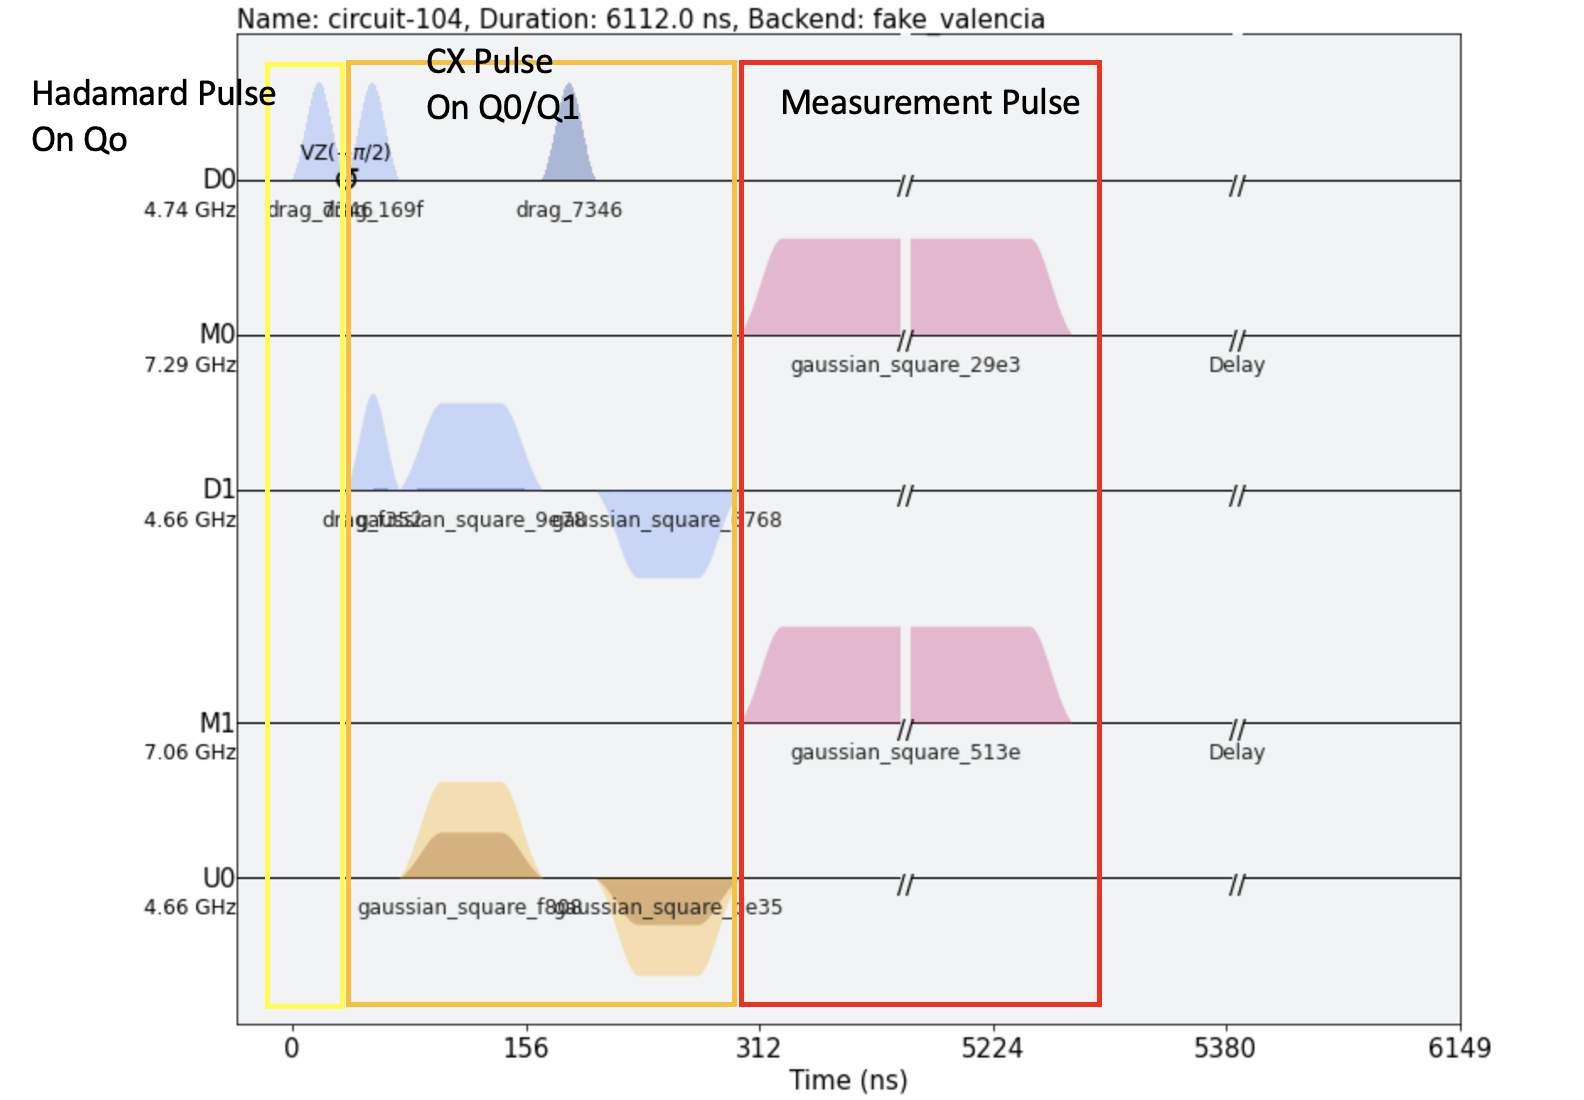

The main purpose of this challenge is to give you educational materials to help you to do further research or exploration easily, so here, I will skip explaining the foundation of a superconducting qubit and theoretical things related to the dynamics of a qubit in detail.  

이 도전 과제의 목표는 여러분께서 Qiskit pulse을 사용법을 연습해 보시는 것이기때문에 초전도 큐비트나 Circuit QED에대해서는 다루지 않도록 하시겠습니다. 대신 여러분께 도움이 될 수 있는 자료의 목록을 남기도록 하겠습니다. 

Additional materials:
- Introduction to Quantum Computing and Quantum Hardware: 
https://www.qiskit.org/learn/intro-qc-qh, especially Lecture 16 to 21
- Qiskit Seminar Series: Quantum Hardware Design: Energy, Circuits, and Metal | Zlatko Minev
https://www.youtube.com/watch?v=jjdYHZ0qxcY
- CQT Lecture: Qiskit Pulse: Programming Quantum Computers Through the Cloud with Pulses by Nick Bronn
https://www.youtube.com/watch?v=V_as5PufUiU

## Build pulse schedule with the Pulse Builder (Pulse Builder를 사용해 pulse schedule작성하기)

### Builder

To build your own pulse sequence, first you need to prepare a `pulse builder` - packing pulse instruction and deliver this to the transpiler and backend. At below I will show you a very simple example to build a interesting pulse sequence by using builder. In this example, we will play a series of pulses on channels which defined as just an array:

여러분 만의 pulse sequence를 작성하기 위해서는 우선 `pulse builder` - 펄스 지시문을 담고 transpiler와 백엔드에 전달 - 에 대해 알아야 합니다. 

다음의 코드는 숫자값의 배열로 정의된 펄스들을 5개의 채널에 재생하는 pulse sequence를 pulse.build로 작성하는 예시입니다. 

In [ ]:
from qiskit import pulse

dc = pulse.DriveChannel
d0, d1, d2, d3, d4 = dc(0), dc(1), dc(2), dc(3), dc(4)

with pulse.build(name='QHK2022_Pulse') as QHK2022:
    pulse.play([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1 ], d0)
    pulse.play([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1 ], d1)
    pulse.play([1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0 ], d2)
    pulse.play([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0 ], d3)
    pulse.play([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1], d4)


draw(QHK2022)

At this code, you can see I briefly decalred 5 drive channels to play a pulse and play a constant pulse to make a lovely feature. You cannot play this pulse at the actual backend because there is no information about the each qubit and the classical register with each drive channel and also, there is a limit on pulse duration comes from the actual backend - usually the minimum duration of each pulse sequence need to be more than 64 (the actual running time is $64*0.222ns \approx 14ns$).


이 코드에서 저는 총 5개의 펄스를 재생하는 drive channel - d0, d1, d2, d3, d4 -를 설정했고 0과 1로 구성된 숫자 어레이로 멋진 모양을 만들었습니다. 이 펄스 sequence는 큐빗 채널에 대한 정보와 레지스터에 대한 정보를 포함에 실제 백엔드와 연결된 값을 갖고 있지 않기 때문에 실제 백엔드에서는 실행되지다. 만약 여러분이 채널 설정에 성공했다 하더라도 실제 백엔드는 실행에 필요한 최소 펄스 길이가 정해져 있기 때문에 역시 위의 펄스는 재생되지 않습니다. 
일반적으로 각 펄스들은 최소 64 step(실제 실행 시간은 $64*0.222ns \approx 14ns$ )이상의 길이로 설정되어야 합니다. 


### Channels

To play pulse at the actual backend, we need to define the exact drive channel. And below is an example how to get the exact qubit information of the backend. Here we are using FakeValencia, which has exactly same hardware composition with the ibmq_valencia.

펄스를 실제 백엔드에서 실행하려면 먼저 정확한 재생 채널 (drive channel)을 설정해 주어야 합니다. 아래의 코드는 백엔드(ibmq_valencia)의 각 큐빗에 펄스를 재생하기 위해 사용해야 하는 drive channel을 보여줍니다. 

In [ ]:
with pulse.build(backend) as drive_sched_check:
    for i in range(5):
        print("The driveing channel of qubit{} is {}".format(i, pulse.drive_channel(i)))

The control channel is the secondary drive channel for the given qubit – typically utilized for controlling multi-qubit interactions. it depends upon the qubit connectivity of a backend. for our examples,

Control channel은 주어진 큐빗의 두번째 drive channel로 보통 멀티 큐비트 제어에 사용됩니다. 
control channel정보는 백엔드의 connectivy에 따라 결정됩니다. 실습에 사용중인 백엔드로 확인해 보겠습니다.

In [ ]:
from qiskit.tools.jupyter import *
backend

The Q0 is connected with Q1 but not with Q2. So if we try to find a drive channel of Q0 with the connectivity (0,1) and (0,2), the result will be different.

Q0는 Q1와는 연결되어 있지만 Q2와는 연결되어 있지 않습니다. 따라서 Q0에 대해서 (0,1)과 (0,2)의 connectivity에 대해 drive channel을 찾는다면 둘중 하나는 에러를 반환합니다. 

In [ ]:
#check the control channel btw 0-1
with pulse.build(backend) as control_sched_check:
    print("The control channel of qubit btw qubit (0,1) is {}".format(0, pulse.control_channels(0,1)))

In [ ]:
with pulse.build(backend) as control_sched_check:
    print("The control channel of qubit btw qubit (0,2) is {}".format(0, pulse.control_channels(0,2)))

As you can see, it returns error. Let's do more example with the pulse channel info inside of the pulse builder: 

에러에서 볼수있듯이 0-2의 사이에 control channel을 찾을 수 없습니다. 
큐빗들을 측정하기 위해서는 각각 Acquire channel과 measure chennel이 필요합니다. 각 큐빗의 채널들을 확인해 보겠습니다.

In [ ]:
with pulse.build(backend) as drive_sched_check:
    for i in range(5):
        print("The acquire channel of qubit{} is {}".format(i, pulse.acquire_channel(i)))
        print("The measurement channel of qubit{} is {}".format(i, pulse.measure_channel(i)))

By using this pulse.channel_info() command, you can bring the specific channel name which working on the specific qubit. It usually has same order with the qubit name. 

Qiskit Pulse has 4 type of channels:
- DriveChannel(i): Transmit channel connected to qubit i, with signals typically modulated at a frequcney in resonance with qubit i
- ControlChannel(i): Transmit channel whith signals typically modulated at a frequency off resonant from its associated qubit.
- MeasureChannel(i): Transmit channel connected to the readout resonator of qubit i
- AcqureChannel(i) : Receive channel connected to the readout resonator of qubit and stor result into a register slot


pulse.channel_info() 명령어를 사용하면 각 큐빗에 작용하는 채널들의 이름을 확인할 수 있습낟. 보통 큐빗의 이름과 같은 순서로 할당이 됩니다.  

Qiskit Pulse에는 네가지 채널이 있습니다.:
- DriveChannel(i): qubit i에 연결된 전송 채널, 신호는 일반적으로 qubit i와 공진하는 주파수에서 변조됩니다.
- ControlChannel(i): 관련 큐비트에서 공진하지 않는 주파수에서 일반적으로 변조된 신호를 사용하는 보조 전송 채널, 멀티 큐빗 제어에 사용
- MeasureChannel(i): 큐비트 i의 판독 공진기에 연결된 전송 채널
- AcqureChannel(i) : 큐비트의 판독 공진기에 연결된 수신 채널, 레지스터 슬롯에 결과 저장

### instructions

After getting some information about the physical channel information of a qubit inside of the PulseBuilder, we can send some `instruction` to tell the hardware do actual pulse operation. Here is the simple example for this:

PulseBuilder 내부에서 큐비트의 물리적 채널 정보에 대한 정보를 얻은 후 하드웨어에 실제 펄스 작업을 수행하도록 지시하는 `instruction`을 보낼 수 있습니다. 이에 대한 간단한 예는 다음과 같습니다.

In [ ]:
with pulse.build(backend) as actual_playing:
    d0 = pulse.drive_channel(0)

    a0 = pulse.acquire_channel(0)

    #play square constant pulse at drive channel 0 with the duration 10 (computational duration) amplitude 1.0
    pulse.play(pulse.library.Constant(64, 1.0), d0)

    #give 20 steps of delay to the d0
    pulse.delay(20, d0)
    #give pi/2 phase shift to the d0 
    pulse.shift_phase(2, d0)
    pulse.play(pulse.library.Constant(64, 1.0), d0)

    #set phase of d0 as pi
    pulse.set_phase(0.5, d0)
    pulse.play(pulse.library.Constant(64, 1), d0)
    
    #define inner pulse schedule inside of the pulse builder
    with pulse.build() as inner_sched:
        #play a gaussian pulse with duration 20, amplitude 1, sigma 3.0 to d0
        pulse.play(pulse.library.Gaussian(64, 0.2, 3.0), d0)
    #play inner schedule at the main schedule
    pulse.call(inner_sched)

draw(actual_playing, backend = backend)

There four major instruction in Qiskit pulse to compose a pulse schedule:
- Play: Output the waveform described by pulse on the pulse channel
- Delay: Idle the pulse channel for the given duration
- shift_phase / shift_frequency : Increase the phase of the chennel/ set the frequency of the channel, usually blocked in using inside of the pulse builder for the stable operation.So if you want to change drive frequency of a qubit, you need to set a outside loop for this and you will learn how to do this at Part2 lecture.
- Acquire: Trigger the acquire channel to collect date for the given duration and store the measurement result in a register

펄스 schedule을 구성하기 위해 Qiskit 펄스에는 네 가지 주요 instruction을 사용합니다.
- Play: 펄스 채널에 펄스 파형을 출력합니다.
- Delay: 주어진 시간 동안 펄스 채널을 유휴 상태로 유지합니다.
- shift_phase / shift_frequency : 채널의 위상을 높이거나 채널의 주파수를 설정합니다. 일반적으로 안정적인 동작을 위해 펄스 빌더 내부에서 사용이 차단됩니다. 따라서 큐비트의 구동 주파수를 변경하려면 builder 바깥에 반복문을 작성해야 합니다. [이곳](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html)에서 예제를 확인 할 수 있습니다.
- Acquire: 획득 채널을 트리거하여 주어진 duration 동안 date를 수집하고 측정 결과를 레지스터에 저장합니다.

### Contexts

In composing multi qubit sequence, qiskit pulse provide you an alignment options to build pulse easily. Below example added one more qubit to compose pulse schedule and you can see `default_alignment` options. If you change it, you can see a different pulse schedule like below. Try other options by remove #:

다중 큐비트 시퀀스를 구성할 때 qiskit 펄스는 펄스를 쉽게 생성할 수 있는 정렬 옵션을 제공합니다. 아래 예제는 펄스 스케줄을 구성하기 위해 두개의 큐비트를 사용했으며 `default_alignment` 옵션을 사용해 볼 수 있습니다. #을 제거하여 다른 옵션을 적용해보시고 차이를 확인해 보세요:

In [ ]:
with pulse.build(backend) as actual_playing:

#with pulse.build(backend, default_alignment='left') as actual_playing:
#with pulse.build(backend, default_alignment='right') as actual_playing:
#with pulse.build(backend, default_alignment='sequential') as actual_playing_two:


    d0 = pulse.drive_channel(0)
    d1 = pulse.drive_channel(1)
    a0 = pulse.acquire_channel(0)

    #play square constant pulse at drive channel 0 with the duration 10 (computational duration) amplitude 1.0
    pulse.play(pulse.library.Constant(64, 1.0), d0)
    pulse.play(pulse.library.Constant(64, 1.0), d1)


    #give 20 steps of delay to the d0
    pulse.delay(20, d0)
    #give pi/2 phase shift to the d0 
    pulse.shift_phase(2, d0)
    pulse.play(pulse.library.Constant(10, 1.0), d0)

    #set phase of d0 as pi
    pulse.set_phase(0.5, d0)
    pulse.play(pulse.library.Constant(64, 1.0), d0)
    
    #define inner pulse schedule inside of the pulse builder
    with pulse.build() as inner_sched:
        #play a gaussian pulse with duration 20, amplitude 1, sigma 3.0 to d0
        pulse.play(pulse.library.Gaussian(64, 1.0, 3.0), d0)
    #play inner schedule at the main schedule
    pulse.call(inner_sched)

draw(actual_playing_two, backend = backend)

### Macros

Next step is measuring our pulse sequence. For this, Qiskit provide some `macros` - predefined functions. You can check the whole macro command of Qiskit pulse at [here](https://qiskit.org/documentation/apidoc/pulse.html). The most wide used and useful `macro` is `measure`. By using this, let's measure our pulse sequence.

다음 단계는 펄스 시퀀스를 측정하는 것입니다. 이를 위해 Qiskit은 사전 정의된 기능인 '매크로'를 제공합니다. Qiskit 펄스의 전체 매크로 명령은 [여기](https://qiskit.org/documentation/apidoc/pulse.html)에서 확인할 수 있습니다. 가장 널리 사용되고 유용한 '매크로'는 'measure'입니다. 이를 사용하여 펄스 시퀀스를 측정해 보겠습니다. 재생하는 펄스는 직전에 작성한 "actual_playing"을 사용해 보겠습니다.

In [ ]:
with pulse.build(backend, default_alignment='sequential') as meas:
    pulse.call(actual_playing)
    
    with pulse.align_left():
        pulse.measure(0)

draw(meas, style=IQXDebugging(), backend = backend)

And let's run this pulse schedule at our backend.

이제 이 펄스 시퀀스를 백엔드에서 실행해 보겠습니다.

In [ ]:
result = backend.run(meas, shots=8192).result()

result.get_counts()

### Circuit Gates

You can also use pre-defined circuit gates inside of the pulse builder. It supports:
- cx(control, target)
- u1(theta, qubit)
- u2(phi, lam, qubit)
- u3(theta, phi, lam, qubit)

So we can compuse upper entanglement gate operation by using this inside of the pulse builder. Let's try this.

Pulse Builder에서 사전 정의된 회로 게이트를 사용할 수도 있습니다. 다음을 지원합니다:

- cx(control, target)
- u1(theta, qubit)
- u2(phi, lam, qubit)
- u3(theta, phi, lam, qubit)

이 사전 정의된 게이트를 사용해서 위에서 사용했던 얽힘 회로를 구현하고 측정해 보겠습니다.

In [ ]:

with pulse.build(backend, default_alignment='sequential') as entangle_circ:
    pulse.u2(0, np.pi, 0)
    pulse.cx(0,1)
    
    with pulse.align_left():
        pulse.measure(0)
        pulse.measure(1)
    
draw(entangle_circ, style=IQXDebugging(), backend=backend)


# Part2: Challenge! 도전 문제!

Among the following four predefined pulse schedules, 1) what is most similar to the X-gate 2) what is most similar to the H-gate and submit your answer.


다음의 미리 정의된 네가지 펄스 스케쥴들 중 1) X게이트와 가장 유사한 성능을 보이는 것 2) H 게이트와 가장 유사한 성능을 보이는 것을 찾아 답안을 제출하시오.

- example1: Square pulse1
- example2: Square pulse2
- example3: Gaussian pulse1
- example4: Gaussian pulse2


In [ ]:
with pulse.build(backend, default_alignment='sequential') as example1:

    d0 = pulse.drive_channel(0)
    #play square constant pulse at drive channel 0 with the duration 200 (computational duration) amplitude 0.5
    pulse.play(pulse.library.Constant(200, 0.5), d0)



draw(example1, backend = backend)

In [ ]:
with pulse.build(backend, default_alignment='sequential') as example2:

    d0 = pulse.drive_channel(0)
    #play square constant pulse at drive channel 0 with the duration 189 (computational duration) amplitude 0.5
    pulse.play(pulse.library.Constant(189, 0.5), d0)



draw(example2, backend = backend)

In [ ]:
with pulse.build(backend, default_alignment='sequential') as example3:

    d0 = pulse.drive_channel(0)
    #play gaussian pulse at drive channel 0 with the duration 160 (computational duration) amplitude 0.2 with sigma=40
    pulse.play(pulse.library.Gaussian(duration=160, amp=(0.2), sigma=40), d0)



draw(example3, backend = backend)

In [ ]:
with pulse.build(backend, default_alignment='sequential') as example4:

    d0 = pulse.drive_channel(0)
    #play gaussian pulse at drive channel 0 with the duration 160 (computational duration) amplitude 0.4 with sigma=40
    pulse.play(pulse.library.Gaussian(duration=160, amp=(0.5), sigma=40), d0)



draw(example4, backend = backend)

In [ ]:
with pulse.build(backend, default_alignment='sequential') as measure:
    
    a0 = pulse.acquire_channel(0)
    m0 = pulse.MeasureChannel(0)

#commenting out and insert pulse schedule you want to play ex:pulse.call(test_pulse1)
    
    #pulse.call()
    
    pulse.acquire(500, m0, pulse.MemorySlot(0))

result = backend.run(measure, shots=8192).result()
result.get_counts()

###  [Submit Answer 정답 제출](https://surveyl.ink/iMGrRL)

2월 10일, 15:00까지

Challenge topic made by: Sophy